# Regresión Lineal Simple

En este notebook vamos a crear un modelo lineal simple para explicar el precio de venta de las propiedades en Capital Federal reportadas por la empresa Properati durante el año 2019.

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Preparación del Dataset

In [2]:
df=pd.read_csv("https://drive.google.com/uc?export=download&id=1wdbORqKzH2FTId7hZ8Gy5HO6Qr03g9bx")

In [3]:
df.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,property_type,operation_type
0,S0we3z3V2JpHUJreqQ2t/w==,Propiedad,2019-04-14,2019-06-14,2019-04-14,-34.943312,-54.929656,Uruguay,Maldonado,Punta del Este,...,NaN,1.0,45.0,40.0,13000.0,UYU,Mensual,Departamento - Roosevelt,Departamento,Alquiler
1,kMxcmAS8NvrynGBVbMOEaQ==,Propiedad,2019-04-14,2019-04-16,2019-04-14,-34.631810,-58.420599,Argentina,Capital Federal,Boedo,...,NaN,NaN,NaN,NaN,0.0,NaN,Mensual,PH - Boedo,PH,Venta
2,Ce3ojF+ZTOkB8d+LI9dpxg==,Propiedad,2019-04-14,9999-12-31,2019-04-14,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,NaN,...,NaN,1.0,200.0,NaN,NaN,NaN,NaN,Ituzaingo 1100 - $ 1 - Casa Alquiler,Casa,Alquiler
3,AUGpj3raGmOCiulSMGIBPA==,Propiedad,2019-04-14,9999-12-31,2019-04-14,-34.654705,-58.790894,Argentina,Bs.As. G.B.A. Zona Oeste,Moreno,...,NaN,2.0,460.0,100.0,NaN,NaN,Mensual,Dr. Vera 300 - Consulte precio - Casa en Venta,Casa,Venta
4,m+MwZmJl3OoxmfWcB//sBA==,Propiedad,2019-04-14,2019-07-09,2019-04-14,-34.654949,-58.787117,Argentina,Bs.As. G.B.A. Zona Oeste,Moreno,...,NaN,3.0,660.0,148.0,NaN,NaN,Mensual,L. N. Alem 2400 - Consulte precio - Casa en ...,Casa,Venta


Vemos que el set de datos contiene propiedades de otras ciudades de Argentina y también de otos países.

In [4]:
df.l1.value_counts()

Argentina         374977
Uruguay            13575
Estados Unidos       305
Brasil                34
Name: l1, dtype: int64

In [5]:
df.l2.value_counts()

Capital Federal                 124327
Bs.As. G.B.A. Zona Norte         72088
Santa Fe                         36199
Buenos Aires Costa Atlántica     30649
Bs.As. G.B.A. Zona Oeste         28576
Bs.As. G.B.A. Zona Sur           28080
Córdoba                          22805
Buenos Aires Interior             8654
Maldonado                         6922
Montevideo                        5922
Neuquén                           4624
Río Negro                         3290
Mendoza                           3097
Tucumán                           2395
Entre Ríos                        2237
Misiones                          1773
Salta                             1501
La Pampa                           947
San Luis                           849
Chubut                             594
San Juan                           539
Chaco                              510
Canelones                          380
Jujuy                              306
Tierra Del Fuego                   300
Colonia                  

Vamos a seleccionar aquellos registros que cumplan las siguientes condiciones:

- Pertenecen a Argentina y Capital Federal
- El precio de venta está en dólares (USD)
- El tipo de propiedad sea: Departamento, PH o Casa
- El tipo de operacion sea Venta

Además conservaremos sólo las variables id, l3, rooms, bedrooms, bathrooms, surface_total, surface_covered, price y property_type.

In [6]:
ubicacion=(df['l2']=='Capital Federal') & (df['l1']=='Argentina')

moneda=df['currency']=='USD'

tipo_propiedad=df.property_type.isin(['Departamento','PH','Casa'])

operacion=df['operation_type']=='Venta'

atributos=['id','l3','rooms','bedrooms','bathrooms','surface_total','surface_covered','price','property_type']

In [7]:
#import collections
#collections.Counter(ubicacion)
#df[ubicacion]

In [8]:
df_filtrado=df[ubicacion & tipo_propiedad & moneda & operacion][atributos]
df_filtrado.head()

,id,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
254,oyj+f764ALCYodIqBvWAww==,Barracas,NaN,NaN,NaN,300.0,180.0,320000.0,PH
262,HdjpKrqdwYfH9YU1DKjltg==,Boedo,6.0,NaN,2.0,178.0,240.0,500000.0,Casa
270,YwWE3rTb2+gmsBwjUHmAPQ==,Palermo,NaN,NaN,2.0,240.0,157.0,350000.0,Casa
273,6AxnSWOhbIU8TUCqb+paBg==,Belgrano,3.0,NaN,4.0,157.0,NaN,470000.0,Casa
275,U4fk+co3Rd8JDMot0pQI6Q==,Versalles,NaN,NaN,1.0,140.0,110.0,155000.0,Casa


In [9]:
df_filtrado.shape

(61905, 9)

### Analisis Exploratorio y Preprocesamiento

Analicemos la cantidad de valores faltantes (NAs) para cada una de las variables.

In [10]:
df_filtrado.isnull().sum() 

id                     0
l3                   355
rooms               5314
bedrooms           25298
bathrooms           3196
surface_total       3671
surface_covered     2975
price                  0
property_type          0
dtype: int64

In [11]:
df_filtrado.isnull().sum() *100 / len(df_filtrado.index)

id                  0.000000
l3                  0.573459
rooms               8.584121
bedrooms           40.865843
bathrooms           5.162749
surface_total       5.930054
surface_covered     4.805751
price               0.000000
property_type       0.000000
dtype: float64


Grafiquemos la matriz de correlaciones para las variables numéricas.
- ¿Cómo es la correlación entre entre rooms y bedrooms? ¿Y la correlación entre surface_total y surface_covered ?

- To Do:  ¿Cómo es la correlación de la variable a explicar, price, con el resto de las variables?

In [12]:
matriz_correlacion=df_filtrado.corr()
matriz_correlacion

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
rooms,1.000000,0.923822,0.625746,0.081698,0.091999,0.304187
bedrooms,0.923822,1.000000,0.626678,0.078930,0.084355,0.341370
bathrooms,0.625746,0.626678,1.000000,0.086070,0.096338,0.420638
surface_total,0.081698,0.078930,0.086070,1.000000,0.694418,0.076642
surface_covered,0.091999,0.084355,0.096338,0.694418,1.000000,0.092363
price,0.304187,0.341370,0.420638,0.076642,0.092363,1.000000


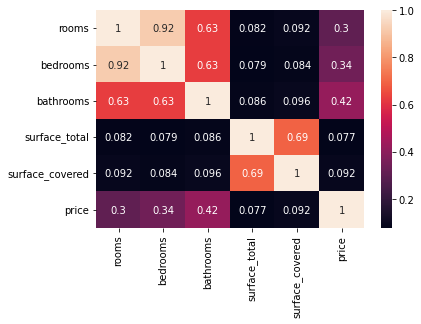

In [13]:
sns.heatmap(matriz_correlacion, annot = True)
 
plt.show()

En la matriz de correlaciones se observa que las variables rooms y bedrooms presentan una fuerte asociación lineal positiva, el coeficiente de correlación es 0.92 (valor muy cercano a 1 o asociación perfecta). 
También vimos que bedrooms presenta un 40% de valores faltantes, por lo tanto, vamos a eliminarla de nuestro dataset.

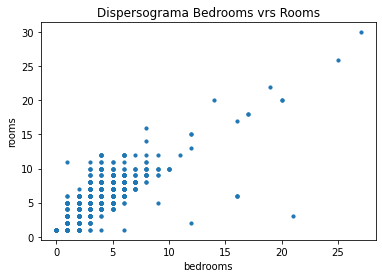

In [14]:
grf=df_filtrado.plot.scatter(x="bedrooms", y="rooms", s=10).set(title="Dispersograma Bedrooms vrs Rooms",xlabel='bedrooms',ylabel='rooms') 

In [15]:
df_filtrado.drop('bedrooms',axis='columns',inplace=True)

Vamos a eliminar todos los valores faltantes de nuestro dataset, recordemos las proporciones que existen para cada variable:

- l3: 0.573459%
- rooms:  8.584121%
- bathrooms: 5.162749%
- surface_total: 5.930054%
- surface_covered: 4.805751%

In [16]:
df_filtrado.dropna(inplace=True)
df_filtrado.shape

(51210, 8)

Las variables surface_total y surface_covered presentan una asociación lineal positiva, si bien la relación es moderada (0.69), la fuerza de la asociación es una de las mayores del dataset. Vamos un dispersograma de ambas variables

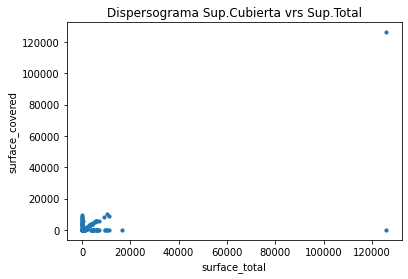

In [17]:
grf=df_filtrado.plot.scatter(x="surface_total", y="surface_covered", s=10).set(title="Dispersograma Sup.Cubierta vrs Sup.Total",xlabel='surface_total',ylabel='surface_covered') 
#c=color s=size

Vamos a eliminar aquellos registros en los cuales la superficie total es menor a la superficie cubierta

In [18]:
sup_inconsistente=df_filtrado[df_filtrado['surface_covered']>df_filtrado['surface_total']].index

df_filtrado.drop(sup_inconsistente, axis='index',inplace=True)

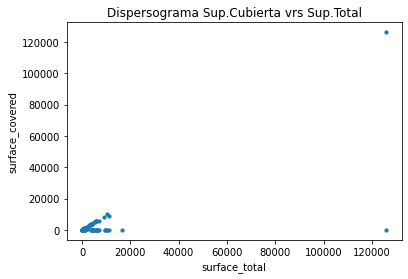

In [19]:
grf=df_filtrado.plot.scatter(x="surface_total", y="surface_covered", s=10).set(title="Dispersograma Sup.Cubierta vrs Sup.Total",xlabel='surface_total',ylabel='surface_covered') 
#c=color s=size

#### Valores atípicos

Tratemos de encontrar aquellos valores que parecerían ser "raros" en nuestros datos.

In [20]:
df_filtrado[['rooms','bathrooms','surface_total','surface_covered','price']].agg(['min','max'])

,rooms,bathrooms,surface_total,surface_covered,price
min,1.0,1.0,12.0,2.0,6000.0
max,32.0,14.0,126062.0,126062.0,6000000.0


In [21]:
np.arange(10, 50, 10)

array([10, 20, 30, 40])

In [22]:
#Percentiles
#df_filtrado.quantile(np.arange(0.00,1.01,0.01))

#Deciles
df_filtrado.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])


,rooms,bathrooms,surface_total,surface_covered,price
0.1,1.0,1.0,36.0,33.0,90000.0
0.2,2.0,1.0,42.0,38.0,110000.0
0.3,2.0,1.0,49.0,44.0,127000.0
0.4,2.0,1.0,56.0,50.0,147178.8
0.5,3.0,1.0,66.0,59.0,170000.0
0.6,3.0,1.0,78.0,68.0,200000.0
0.7,3.0,2.0,95.0,81.0,248000.0
0.8,4.0,2.0,122.0,102.0,310000.0
0.9,4.0,3.0,176.0,149.0,450000.0
1.0,32.0,14.0,126062.0,126062.0,6000000.0


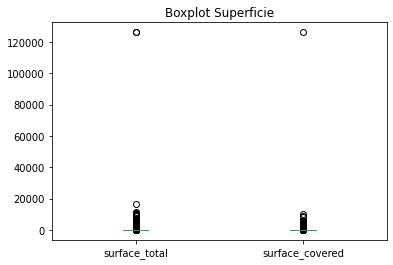

In [23]:
# Boxplot superficies
grf=df_filtrado[['surface_total','surface_covered']].plot.box(title="Boxplot Superficie")

In [24]:
# TODO
#¿Qué visualizaciones podrían ser útiles en este punto? 

In [25]:
#Superficie Total
sup_max=df_filtrado[df_filtrado['surface_total']> 176].index
sup_min=df_filtrado[df_filtrado['surface_total']< 36].index

df_filtrado.drop(sup_max, axis='index',inplace=True)
df_filtrado.drop(sup_min, axis='index',inplace=True)

In [26]:
#Superficie Cubierta
sup_max=df_filtrado[df_filtrado['surface_covered']> 149].index
sup_min=df_filtrado[df_filtrado['surface_covered']< 33].index

df_filtrado.drop(sup_max, axis='index',inplace=True)
df_filtrado.drop(sup_min, axis='index',inplace=True)

In [27]:
# TODO
#¿Qué visualizaciones podrían ser útiles en este punto para la variable price? 

In [28]:
#Price
price_max=df_filtrado[df_filtrado['price']> 450000].index
price_min=df_filtrado[df_filtrado['price']< 90000].index

df_filtrado.drop(price_max, axis='index',inplace=True)
df_filtrado.drop(price_min, axis='index',inplace=True)

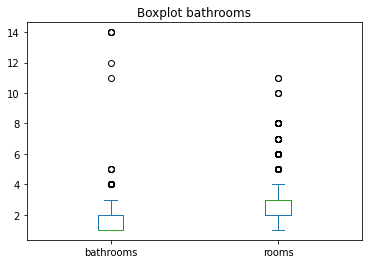

In [29]:
# Rooms y Bathrooms
grf=df_filtrado[['bathrooms','rooms']].plot.box(title="Boxplot bathrooms")

In [30]:
#Rooms y bathrooms
broom_max=df_filtrado[df_filtrado['bathrooms']> 4].index
room_max=df_filtrado[df_filtrado['rooms']>6].index

df_filtrado.drop(broom_max, axis='index',inplace=True)
df_filtrado.drop(room_max, axis='index',inplace=True)

In [31]:
df_filtrado.shape

(35627, 8)

Como resultado del preprocesamiento, se obtiene un set de datos con 35.627 observaciones que corresponden a propiedades en venta en CABA (Casa, Departamento o PH) con las siguientes características:

- Precio de Venta: entre 90.000 y 450.000 USD
- Supercie Total: entre 36 y 176 mts2
- Supercie Cubierta: entre 33 y 149 mts2
- Cantidad de Habitaciones: entre 1 a 6 habitaciones
- Cantidad de Baños: entre 1 a 4 baños

Finalmente creamos una variable que sea la variable price divida por 1000. La llamaremos precio en miles y será nuestro target en el modelo lineal.

In [32]:
df_filtrado['precio_miles']=df_filtrado['price']/1000

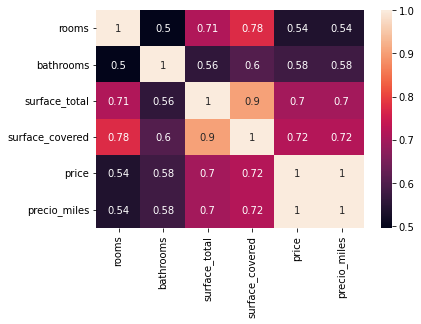

In [33]:
sns.heatmap(df_filtrado.corr(), annot = True)

TO DO : ¿Cómo es la correlación de la variable a explicar, price (o precio_miles), con el resto de las variables? ¿Qué diferencias encuentran con la matriz que calculamos antes de trabajar sobre los valores atípicos?

### Modelo Lineal Simple

Vamos a proponer dos modelos lineales simples y  trataremos de seleccionar uno de ellos para predecir el precio de venta de las propiedades


#### Modelo 1: para explicar el precio (en miles) en función de las habitaciones (rooms) 
precio = B0 + B1 * rooms 

In [34]:
modelo_rooms = LinearRegression()

rooms=df_filtrado['rooms'].values.reshape(-1, 1)
precio_miles=df_filtrado['precio_miles'].values.reshape(-1, 1)

modelo_rooms.fit(rooms,precio_miles)

#B1
print(modelo_rooms.coef_)
#B0
print(modelo_rooms.intercept_)

[[43.84475034]]
[75.58493454]


Significado de los coeficientes estimados:

- El valor de la ordenada al origen (B0) es el precio en miles de una propiedad con 0 habitaciones. Es un valor teórico y su interpretación individual no tiene sentido. 

- La pendiente de la recta estimada (B1) nos inica que por cada aumento de una habitacion en la propiedad el precio de venta aumenta en promedio 43.845 miles de USD. 

El modelo que obtuvimos es :  precio = 75.585 + 43.845 * rooms.

¿Cuál sería el precio esperado de venta de una propiedad con 2 habitaciones?

precio = 75.585 + 43.845 * 2 = 163.275 (en miles USD)

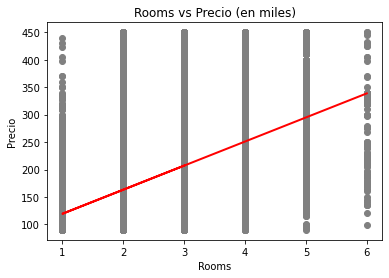

In [35]:
precio_miles_pred = modelo_rooms.predict(rooms)

plt.scatter(rooms, precio_miles, color='gray')
plt.plot(rooms, precio_miles_pred, color='red', linewidth=2)
plt.title('Rooms vs Precio (en miles)')
plt.xlabel('Rooms')
plt.ylabel('Precio')
plt.show()

Vamos a medir la performance del modelo sobre los datos de entrenamiento utilizando las métricas MSE, RMSE y R2

**1) Error Cuadrático Medio (Mean Squared Error)**

Medida de qué tan cercana es la recta de regresión a los puntos que representan los datos. Mientras más chico más cerca está nuestro modelo de los datos reales. Al ser un valor elevado al cuadrado, es sensible a valores de diferencias grandes.
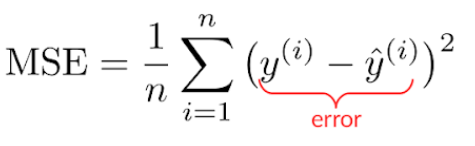

**2) Raíz del Error Cuadrático Medio (Root Mean Squared Error)**

Tiene las mismas unidades que los valores representados en el eje vertical. Es la distancia de un punto hasta la recta de regresión, medida en línea recta. Mide el desvío estándar (cuánto se alejan los valores de la media).

**3) R2**

Es la proporcion de variabilidad explicada por el modelo, se lo determina coeficiente de determinación. No depende de las unidades de medida y su valor está entre 0 y 1 .

Cuando R2=0 el modelo se ajusta poco a la varibilidad de los datos.Por el contrario R2=1 se ajusta mucho a la variabilidad de los datos.

Mientras mayor es R2, mayor es la fuerza de la variable regresora para predecir la variable respuesta.




In [36]:
#Metricas
print("MSE: " + str(metrics.mean_squared_error(precio_miles, precio_miles_pred, squared=True)))
print("RMSE: " + str(metrics.mean_squared_error(precio_miles, precio_miles_pred, squared=False)))
print("R2: "+str(metrics.r2_score(precio_miles, precio_miles_pred)))

MSE: 4701.096399014832
RMSE: 68.564541849376
R2: 0.28928576535984596


#### Modelo 2: para explicar el precio (en miles) en función de la superficie total (surface_total).

precio = B0 + B1 * surface_total

In [37]:
modelo_surface = LinearRegression()

surface_total=df_filtrado['surface_total'].values.reshape(-1, 1)
precio_miles=df_filtrado['precio_miles'].values.reshape(-1, 1)

modelo_surface.fit(surface_total,precio_miles)

#B1
print(modelo_surface.coef_)
#B0
print(modelo_surface.intercept_)

[[1.88372727]]
[55.29925078]


TODO:

¿Cuál es el modelo que obtuvimos?

¿Cuál es el significado de los valores de los coeficientes estimados en cada caso.?

¿Cuál sería el precio esperado de venta de una propiedad con 50 mts2 totales?

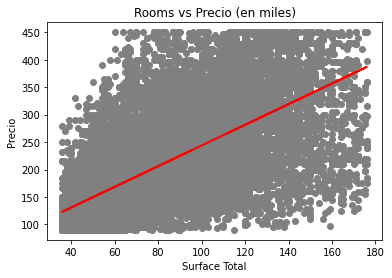

In [38]:
precio_miles_pred = modelo_surface.predict(surface_total)

plt.scatter(surface_total, precio_miles, color='gray')
plt.plot(surface_total, precio_miles_pred, color='red', linewidth=2)
plt.title('Rooms vs Precio (en miles)')
plt.xlabel('Surface Total')
plt.ylabel('Precio')
plt.show()

Vamos a medir la performance del modelo sobre los datos de entrenamiento utilizando las métricas MSE, RMSE y R2

In [39]:
#Metricas
print("MSE: " + str(metrics.mean_squared_error(precio_miles, precio_miles_pred, squared=True)))
print("RMSE: " + str(metrics.mean_squared_error(precio_miles, precio_miles_pred, squared=False)))
print("R2: "+str(metrics.r2_score(precio_miles, precio_miles_pred)))

MSE: 3373.0295007010204
RMSE: 58.07778835924299
R2: 0.4900636199436882


#### Selección del modelo

Para poder comparar los modelos y seleccionar aquél que mejor logra explicar el precio de venta de las propiedades se evalua el R2 (coeficiente de determinación), que representa la capacidad de predicción del modelo.

Entonces el modelo que utiliza la superficie total como variable explicativa tiene el mayor R-cuadrado: R2=0.49 y por lo tanto es el mejor modelo entre los que probamos para explicar el precio de venta de las propiedades que estamos analizando.

#### Predicción

TODO: 

- Con el modelo seleccionado realizar una predicción sobre el conjunto de test disponible en el drive de la materia :ar_properties_test.csv

- Evaluar las métricas MSE RMSE